## Fons van der Plas - Numerical Methods Assignment 4

_Note: using Jupyter's 'Run All' skipped some blocks on my system, so please run each code block individually._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from IPython.display import display, Markdown, Latex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Introduction
We will study the Duffing differential equation:
$$x'' = x - x^3 - \alpha x'$$
for some damping constant $\alpha \in \mathbb{R}_{\geq 0}$.
Written as a first-order differential equation, we have:

$$u'(t) = f(t,u(t))$$

with 

$$f : \mathbb{R}\times\mathbb{R}^2 \rightarrow \mathbb{R}^2 \\
 f: \left(t,\begin{pmatrix} u_0 \\ u_1 \end{pmatrix}\right) \mapsto \begin{pmatrix} u_1 \\ u_0 - u_0^3 - \alpha u_1 \end{pmatrix}.$$





In [2]:
def duffing(u,alpha=0):
    u0, u1 = u
    return np.array([u1, u0*(1 - u0*u0) - alpha*u1])

# 1. Undamped: $\alpha =0$

**b):**

I am using a python [generator](https://realpython.com/introduction-to-python-generators/) to implement Euler's method. A generator can be seen as a (possibly infinite!) list.

For this assignment, I am using generators because:

- By default, the sequence generated by a generator is not stored in memory. This is useful, for example, if we are only interested in finding the _first_ value that meets a certain condition. 
- I want to practice using generators!

In [3]:
def eulers_method(f, u_initial, delta_t, t_initial=0):
    u = u_initial
    
    # itertools.count is a built-in iterator, that produces an 'infinite' sequence of floats
    # similar to range, but without upper limit
    for t in itertools.count(t_initial, delta_t):
        yield u
        u = u + delta_t*f(t,u)

In [4]:
delta_t = 1e-3

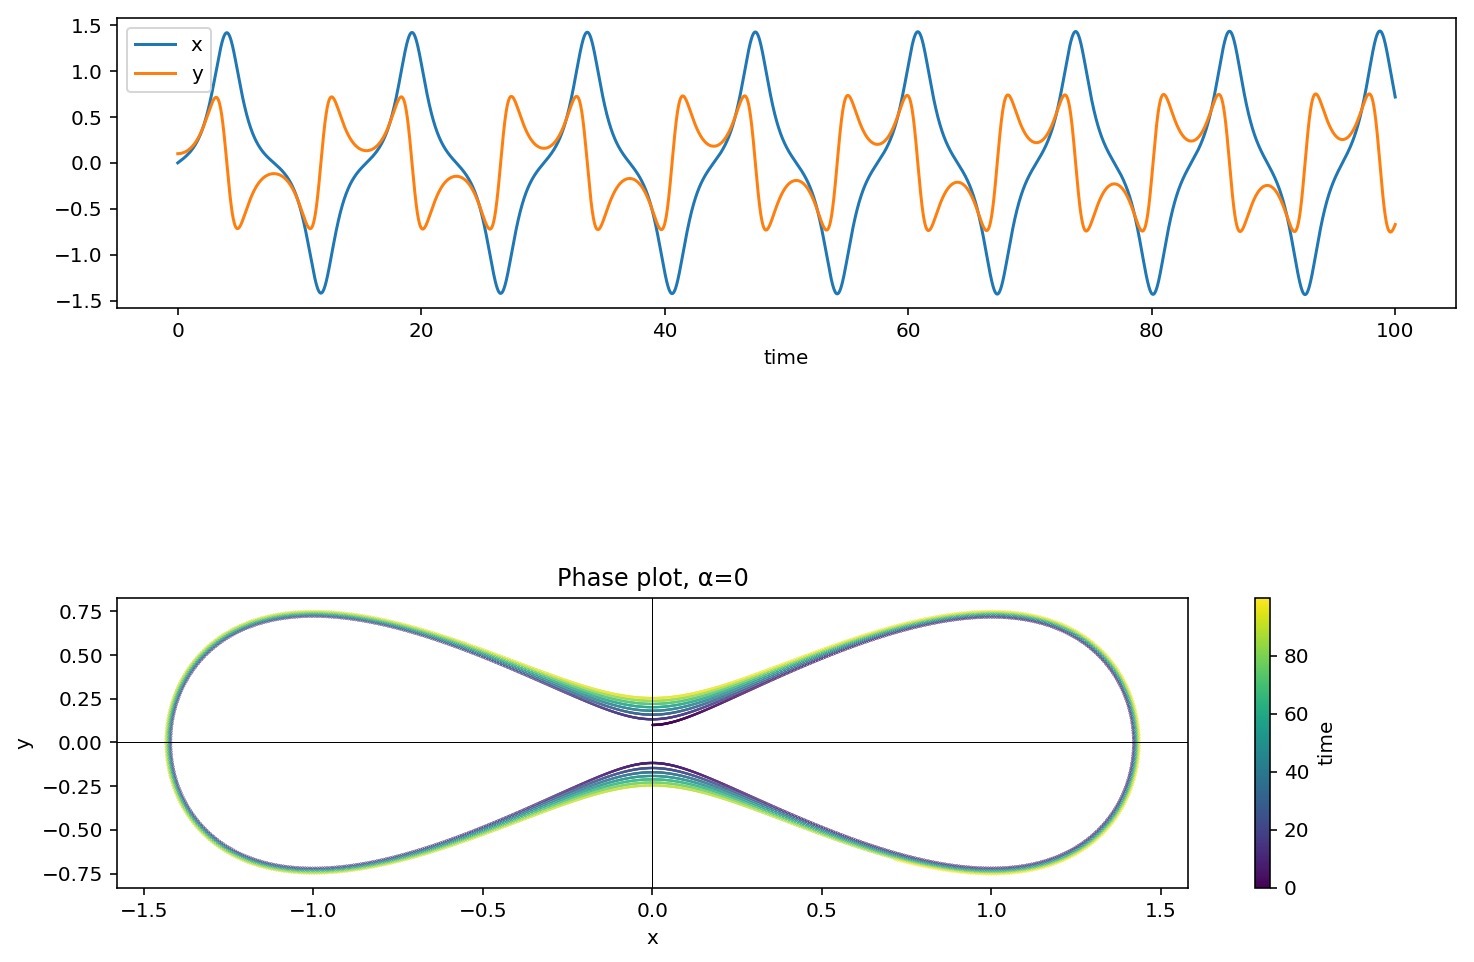

In [5]:
# flow is a generator, creating the sequence
# [0.  0.1] [0.0001 0.1   ] [0.0002    0.1000001] ...etc
flow = eulers_method(f=lambda t,u: duffing(u),
                     u_initial=np.array([0.0,0.1]),
                     delta_t=delta_t)

M = 100000
# Compute the first M points, only saving every tenth point.
firstM_values = list(itertools.islice(flow, 0, M, 10))
x,y = zip(*firstM_values)
t = np.linspace(0, M*delta_t, num=len(firstM_values), endpoint=False)


fig = plt.figure(figsize=(12,8))
# Increase space between the two subplots
fig.subplots_adjust(hspace=1)

plt.subplot(2,1,1)
plt.plot(t,x, label="x")
plt.plot(t,y, label="y")
plt.xlabel("time")
plt.ylabel("")
plt.legend()



plt.subplot(2,1,2)
plt.scatter(x,y, s=.05, c=t)
plt.colorbar(label='time')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Phase plot, α=0")
plt.axhline(0,c='0', linewidth=.5)
plt.axvline(0,c='0', linewidth=.5)


plt.show()

To compute the number of iterations in a cycle, we:
1. Compute new values _until we find a negative $u_0$_. This means that half a cycle is traversed. Then:
1. Compute new values _until we find a positive $u_0$_. This means that another half cycle is traversed. 

## Method 1

In [6]:
def final_cycle_point(flow):
    """
    Given a flow generator, find the first point to cross the y-axis.
    
    Parameters
    ----------
    
    flow : generator, iterator
        Flow of a 2D ODE
    
    Returns
    -------
    int
        Index of first point after a full cycle
    numpy.ndarray
        First point after a full cycle
    
    """
    # flow_enumerated is a new generator, creating the sequence
    # (0, array([0. , 0.1])) (1, array([0.0001, 0.1   ])) (2, array([0.0002   , 0.1000001])) ...etc
    flow_enumerated = enumerate(flow)


    # Compute the first point with a negative x-value:
    half_cycle_index, half_cycle_point = next(((i,u) for i,u in flow_enumerated if u[0] < 0))
    # Compute the first point with a positive x-value:
    full_cycle_index, full_cycle_point = next(((i,u) for i,u in flow_enumerated if u[0] >= 0))

    return full_cycle_index, full_cycle_point

In [7]:
flow = eulers_method(f=lambda t,u: duffing(u),
                     u_initial=np.array([0.0,0.1]),
                     delta_t=delta_t)


N, uN = final_cycle_point(flow)
print(f"Full circle traversed at N={N}, T={N*delta_t}")
print()
print(f"u(t_N)={uN}")

Full circle traversed at N=15496, T=15.496

u(t_N)=[1.92293988e-05 1.32497302e-01]


Great! Unfortunately we also want to know the value $u(t_{N-1})$, to get a more precise estimate of $T$. 

We _could_ simply use Euler's method again calculate $u(t_{N-1})$ directly, since we now know what $N$ will be. 

In [8]:
flow = eulers_method(f=lambda t,u: duffing(u),
                     u_initial=np.array([0.0,0.1]),
                     delta_t=delta_t)

print(f"u(t_(N-1))={next(itertools.islice(flow,N-1,None))}")

u(t_(N-1))=[-1.13268016e-04  1.32497415e-01]


--------

## Method 2

In general, however, this would not be a good strategy, since it requires the flow to be calculated _twice_.


So instead, we will make a modification to the technique above. Instead of iterating over the values 
$$(i, u(t_i))$$
we will iterate over the _pairs of successive_ values:
$$\big((i-1, u(t_{i-1})),\quad (i, u(t_i))\big)$$

Let's define a function that turns a generator of _values_ into a generator of _successions of values_:

as an example, we will print the result for `range(4)`

In [9]:
def successions(iterator):
    previous = next(iterator)
    for nextval in iterator:
        yield previous, nextval
        previous = nextval

print("             range(4): ", list(range(4)))
print("successions(range(4)): ", list(successions(iter(range(4)))))

             range(4):  [0, 1, 2, 3]
successions(range(4)):  [(0, 1), (1, 2), (2, 3)]


Let's apply this to our method.

We will still use Euler's method to compute the flow of $u$, up to the first value that crosses the y-axis, at index $N$.

This time, however, we will not only store $u(t_N)$, but also $u(t_{N-1})$.

In [10]:
def final_two_cycle_points(flow):
    """
    Given a flow generator, find the first point to cross the y-axis.
    
    Parameters
    ----------
    
    flow : generator, iterator
        Flow of a 2D ODE
    
    Returns
    -------
    int
        Index of first point after a full cycle
    numpy.ndarray
        First point after a full cycle
    numpy.ndarray
        Last point *before* a full cycle, computed in the second-to last iteration
    
    """
    flow_enumerated = enumerate(flow)

    # Compute the first point with a negative x-value:
    half_cycle_index, half_cycle_point = next(((i,u) for i,u in flow_enumerated if u[0] < 0))

    # Compute the first point with a positive x-value:

    ### OLD:
    ###    full_cycle_index, full_cycle_point  = next((       (i,u)  for       i,u  in             flow_enumerated  if u[0] >= 0))
    ### NEW:
    prev, (full_cycle_index, full_cycle_point) = next(( (prev,(i,u)) for prev,(i,u) in successions(flow_enumerated) if u[0] >= 0))



    # `prev` is the tuple (N-1, u(t_(N-1))), since it is the value that came before (N,u(t_N)). Let's store u(t_(N-1)):
    almost_full_cycle_point = prev[1]
    
    return full_cycle_index, full_cycle_point, almost_full_cycle_point

In [11]:
flow = eulers_method(f=lambda t,u: duffing(u),
                     u_initial=np.array([0.0,0.1]),
                     delta_t=delta_t)

N, uN, uNminus1 = final_two_cycle_points(flow)
print(f"Full circle traversed at N={N}.")
print()
print(f"u(t_(N-1))={uNminus1}")
print(f"u(t_(N))  ={uN}")

Full circle traversed at N=15496.

u(t_(N-1))=[-1.13268016e-04  1.32497415e-01]
u(t_(N))  =[1.92293988e-05 1.32497302e-01]


-------------

**a):** We now have $(t_{N-1}, u(t_{N-1}))$ and $(t_N, u(t_N))$, with
$$u_0(t_{N-1}) < 0 \leq u_0(t_{N})$$.

We use linear interpolation to find $t_{N-1}<\tilde{T}\leq t_N$ such that $u_0(\tilde{T})\approx u_0(T) = 0$.

For linear interpolation, we can implement the formula ourselves ([formula on wiki](https://en.wikipedia.org/wiki/Linear_interpolation)) or use a built-in method ([numpy docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html)).

In [12]:
Tapprox_euler = np.interp(x=0, 
                          xp=np.array([uNminus1[0], uN[0]]), 
                          fp=delta_t * np.array([N-1, N]))
print(f"T~ = {Tapprox_euler}")

T~ = 15.495854869630092


------------
**c):** 

In [13]:
# at iteration index i:
# 'old' means i
# 'new' means i+1

def explicit_trapeziod_method(f, u_initial, delta_t, t_initial=0):
    u_old = u_initial
    
    # Loop over (t0, t1), (t1, t2), etc...
    for t_old, t_new in successions(itertools.count(t_initial, delta_t)):
        yield u_old
        
        # Evaluate f only once
        f_t_old_u_old = f(t_old, u_old)
        
        u_predictor = u_old +    delta_t *  f_t_old_u_old
        u_new       = u_old + .5*delta_t * (f_t_old_u_old + f(t_new, u_predictor))
        
        # Pass u_old on to the next iteration
        u_old = u_new

In [14]:
flow = explicit_trapeziod_method(f=lambda t,u: duffing(u),
                                 u_initial=np.array([0.0,0.1]),
                                 delta_t=delta_t)

N, uN, uNminus1 = final_two_cycle_points(flow)
print(f"Full circle traversed at N={N}.")
print()
print(f"u(t_(N-1))={uNminus1}")
print(f"u(t_(N))  ={uN}")

Full circle traversed at N=16107.

u(t_(N-1))=[-6.32279382e-05  1.00000050e-01]
u(t_(N))  =[3.67720805e-05 1.00000037e-01]


In [15]:
Tapprox_trapezoid = np.interp(x=0, 
                              xp=np.array([uNminus1[0], uN[0]]), 
                              fp=delta_t * np.array([N-1, N]))
print(f"Euler:              T~ = {Tapprox_euler}")
print(f"Explicit trapezoid: T~ = {Tapprox_trapezoid}")

Euler:              T~ = 15.495854869630092
Explicit trapezoid: T~ = 16.106632279264005


Based on the previous results, we can give an estimate for $\tilde{T}$: $16.1$. We know that the explicit trapezoid method is more accurate, which means that the $\tilde{T}$ value derived using that method is a better guess.

Concerning the error margin, I cannot think of any way to use the order of convergence, $\mathcal{O}(\tau)$ and $\mathcal{O}(\tau^2)$, to say anything about the error margin. 

However, the orders of convergence do tell us that the explicit trapezoid method _is a better method_, and that a smaller value for $\tau$ will give us a result closer to the actual value.

So let's use $\tau = 10^{-5}$ for a good approximation:

In [195]:
delta_t_precise = 1e-5

flow = explicit_trapeziod_method(f=lambda t,u: duffing(u),
                                 u_initial=np.array([0.0,0.1]),
                                 delta_t=delta_t_precise)

N, uN, uNminus1 = final_two_cycle_points(flow)

Tapprox_trapezoid_precise = np.interp(x=0, 
                              xp=np.array([uNminus1[0], uN[0]]), 
                              fp=delta_t_precise * np.array([N-1, N]))

display(Latex("$$τ=10^{-5}, \quad T^\sim = " + "{:0.3f}".format(Tapprox_trapezoid_precise) + "$$"))

<IPython.core.display.Latex object>

# 2. Damped: $\alpha > 0$

In [16]:
alpha_choice = 19/90



We have:
$$u'(t) = f(t,u(t)) = \text{duff}(u(t))$$

with 

$$\text{duff} : \mathbb{R}^2 \rightarrow \mathbb{R}^2 \\
 \text{duff}: \begin{pmatrix} u_0 \\ u_1 \end{pmatrix} \mapsto \begin{pmatrix} u_1 \\ u_0 - u_0^3 - \alpha u_1 \end{pmatrix}.$$

At the origin, $(0,0)$, the differential equation is zero: $\text{duff}((0,0))=(0,0)$, and the constant flow

$$t \mapsto (0,0)$$

is a solution to the differential equation with initial value $u(0)=(0,0)$.

## What happens when u(0) is close to zero?

**a):**

$\text{duff}$ has jacboian matrix:

$$J = 
\begin{pmatrix}
\frac{\partial u_0}{\partial u_0} & \frac{\partial u_0}{\partial u_1} \\
\frac{\partial u_1}{\partial u_0} & \frac{\partial u_1}{\partial u_1}
\end{pmatrix}
= \begin{pmatrix}
0 & 1 \\
1 - 3 u_0^2 & -\alpha
\end{pmatrix} \Big\vert_{(u_0, u_1)=(0,0)}
= \begin{pmatrix}
0 & 1 \\
1 & -\alpha
\end{pmatrix}$$

The eigenvalues are the roots of $\lambda \mapsto \det (J - \lambda I) = (-\lambda)(-\alpha-\lambda) - 1 = \lambda^2 + \alpha \lambda - 1$, which are:

$$\lambda_1 = \frac{-\alpha - \sqrt{\alpha^2 + 4}}{2} < 0$$
$$\lambda_2 = \frac{-\alpha + \sqrt{\alpha^2 + 4}}{2} > 0$$

This means that $(0,0)$ is a saddle point, with two flows leaving the origin, and two flows entering the origin. (Note that these flows _approach_ the origin, but never reach it. Otherwise, by unicity of ODE solutions, they must equal the constant flow, $t \mapsto (0,0)$.) 

The directions of these flows correspond to the eigenvalues of $J$. 

Let's use `sympy` to calculate these! Why 🤔 when you have a 💻?

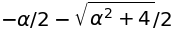

has eigenvector

⎡       ________⎤
⎢      ╱  2     ⎥
⎢α   ╲╱  α  + 4 ⎥
⎢─ - ───────────⎥
⎢2        2     ⎥
⎢               ⎥
⎣       1       ⎦

---

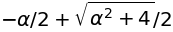

has eigenvector

⎡       ________⎤
⎢      ╱  2     ⎥
⎢α   ╲╱  α  + 4 ⎥
⎢─ + ───────────⎥
⎢2        2     ⎥
⎢               ⎥
⎣       1       ⎦

---

In [17]:
from sympy import Matrix, Symbol, init_printing, pretty
init_printing()

a = Symbol("α")
J = Matrix([[0,1],[1,-a]])

Jeigenvalues = []
Jeigenvectors = []

for eigenvalue, algebraic_mult, eigenvectors in J.eigenvects():
    Jeigenvalues.append(eigenvalue.subs(a, alpha_choice))
    Jeigenvectors.append(np.array(eigenvectors[0].subs(a,alpha_choice)).flatten())
    display(eigenvalue, Markdown("has eigenvector"), eigenvectors[0],Markdown("---"))

In [196]:
display(Markdown("Substituting $α = 19/90$ gives eigenvectors: "))
for eigv in Jeigenvectors:
    print(eigv)

Substituting $α = 19/90$ gives eigenvectors: 

[-0.900000000000000 1]
[1.11111111111111 1]


In the linearised equation, exact solutions are given by:

$$t \mapsto \pm v_i e^t$$

where $v_1, v_2$ are the two eigenvalues.

In a phase plot, these solutions are straight lines from the origin, directed along the eigenvectors. For our equation, we expect the behaviour close to the origin to be the same. When initial values are taken as $\pm \epsilon v_i$, with $\epsilon$ close to zero, the solution should resemble such a straight line.

Let's compute solutions with initial values:

$$\frac{1}{20} v_1, \quad -\frac{1}{20} v_1, \quad \frac{1}{20} v_2, \quad -\frac{1}{20} v_2$$

for T between $-M \tau$ and $M \tau$.

We also use include solutions for initial values:

$$(0.0, 0.1), \quad (0.0, -0.1)$$

to study the sensitivity of the initial value. (Do different initial values _eventually_ result in the same path?)

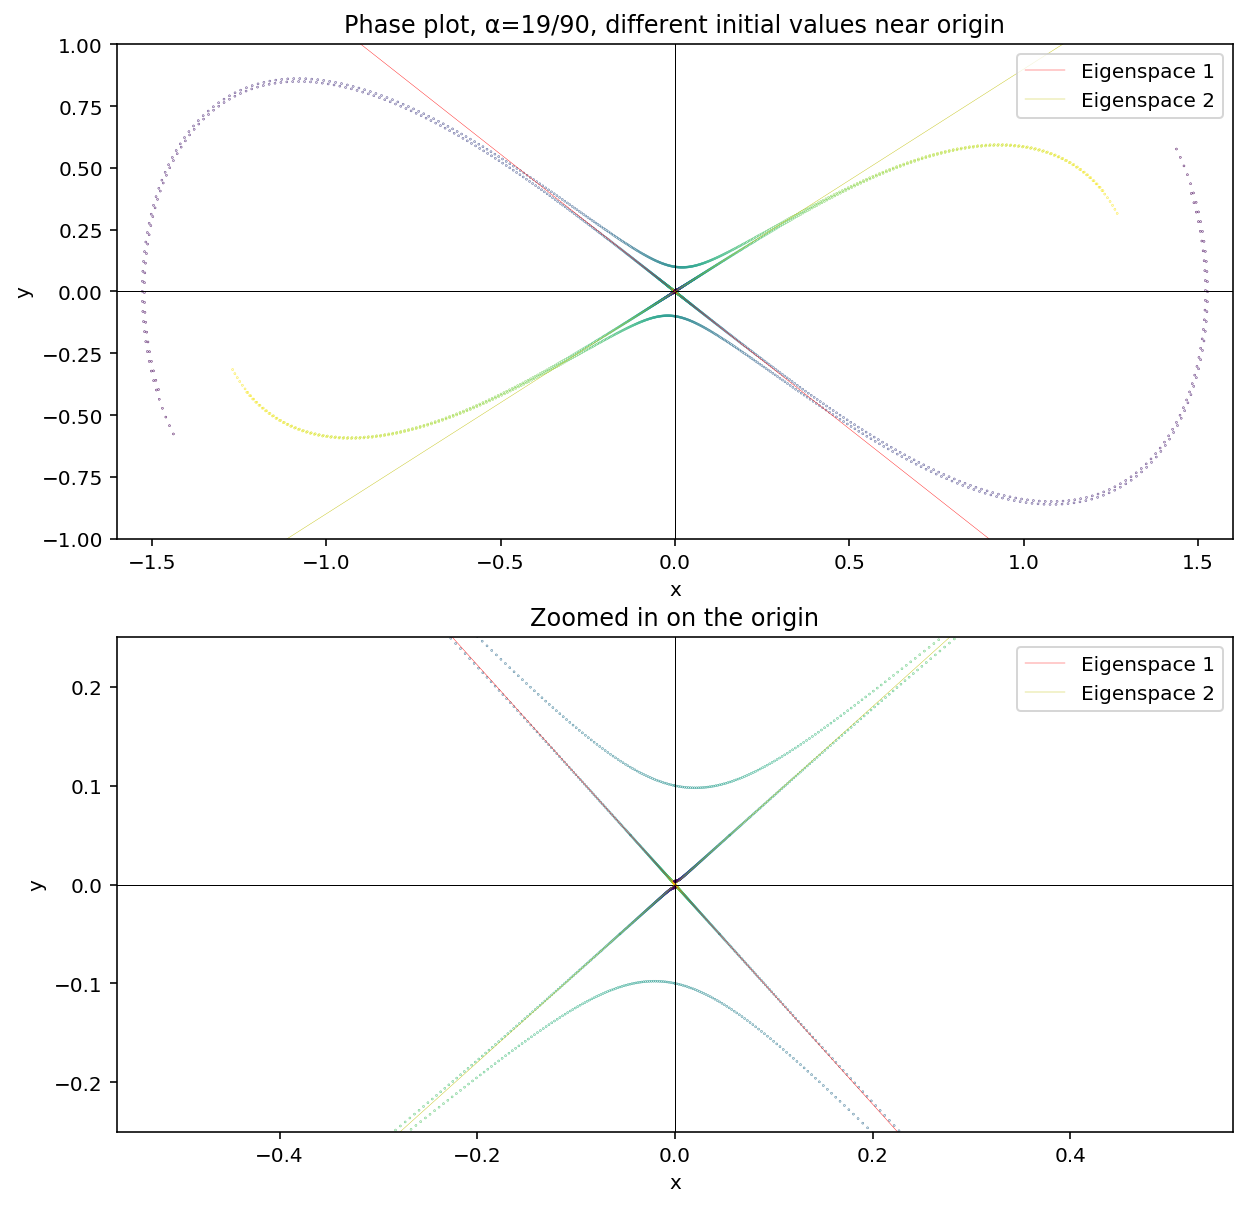

In [197]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.set_title("Phase plot, α=19/90, different initial values near origin")

ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.axhline(0,c='0', linewidth=.5)
ax1.axvline(0,c='0', linewidth=.5)

ax2.set_title("Zoomed in on the origin")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.axhline(0,c='0', linewidth=.5)
ax2.axvline(0,c='0', linewidth=.5)

M = 2000
delta_t_crude = 2*1e-3

for u_initial in [[0.0, 0.1], [0.0, -0.1], 
                  Jeigenvectors[0]*.05,
                  -Jeigenvectors[0]*.05,
                  Jeigenvectors[1]*.05,
                  -Jeigenvectors[1]*.05]:
    flow = explicit_trapeziod_method(f=lambda t,u: duffing(u, alpha=alpha_choice),
                                     u_initial=u_initial,
                                     delta_t=delta_t_crude)
    
    # Use the inverse of the ODE to go 'backwards in time'
    flow_reversed = explicit_trapeziod_method(f=lambda t,u: -duffing(u, alpha=alpha_choice),
                                     u_initial=u_initial,
                                     delta_t=delta_t_crude)

    # Compute the first M points, only saving every tenth point.
    firstM_values   = list(itertools.islice(flow,          0, M, 10))
    firstM_values_r = list(itertools.islice(flow_reversed, 0, M, 10))
    x  ,y   = zip(*firstM_values)
    x_r,y_r = zip(*firstM_values_r)
    t = np.linspace(0, M*delta_t_crude, num=len(firstM_values), endpoint=False)
    ax1.scatter(x,  y,   s=.05, c=t,  vmin=-M*delta_t_crude, vmax=M*delta_t_crude)
    ax1.scatter(x_r,y_r, s=.05, c=-t, vmin=-M*delta_t_crude, vmax=M*delta_t_crude)
    ax2.scatter(x,  y,   s=.05, c=t,  vmin=-M*delta_t_crude, vmax=M*delta_t_crude)
    ax2.scatter(x_r,y_r, s=.05, c=-t, vmin=-M*delta_t_crude, vmax=M*delta_t_crude)

    

eigen_t = [-1.2, 1.2]

ax1.plot(*zip(*[t*Jeigenvectors[0] for t in eigen_t]), 'r-', linewidth=.2, label="Eigenspace 1")
ax1.plot(*zip(*[t*Jeigenvectors[1] for t in eigen_t]), 'y-', linewidth=.2, label="Eigenspace 2")
ax2.plot(*zip(*[t*Jeigenvectors[0] for t in eigen_t]), 'r-', linewidth=.2, label="Eigenspace 1")
ax2.plot(*zip(*[t*Jeigenvectors[1] for t in eigen_t]), 'y-', linewidth=.2, label="Eigenspace 2")

ax1.legend()
ax2.legend()

ax1.set_xlim(-1.6,1.6)
ax1.set_ylim(-1,1)
ax2.axis('equal')
ax2.set_xlim(-.25,.25)
ax2.set_ylim(-.25,.25)


plt.show()

-----------
## Runge Kutta

**b):**
Directly implementing the definition from the lecture notes:

In [20]:
# at iteration index i:
# 'old' means i
# 'new' means i+1

def runge_kutta(f, A, b, u_initial, delta_t, t_initial=0):
    u_old = u_initial
    
    # Make sure that the given tableau describes an *explicit* method:
    if np.triu(A).any():
        raise Warning("Explicit methods are not supported.")
    
    c = A.sum(axis=1)
    s = A.shape[0]
    
    for t_old in itertools.count(t_initial, delta_t):
        yield u_old
        
        v = [np.array(u_old) for _ in range(s)]
        
        for i in range(s):
            for j in range(i):
                if A[i,j] != 0.0:
                    v[i] += delta_t * A[i,j] * f(t_old + c[j]*delta_t, v[j])
        
        u_new = u_old + delta_t * sum(b[i] * f(t_old + c[i]*delta_t, v[i]) for i in range(s))
        
        # Pass u_old on to the next iteration
        u_old = u_new

In [21]:
RK4A = np.array([[.0, .0, .0, .0],
                 [.5, .0, .0, .0],
                 [.0, .5, .0, .0],
                 [.0, .0, 1., .0]])

RK4b = np.array([1/6, 1/3, 1/3, 1/6])

Let's use this new algorithm to draw some colorful lines:

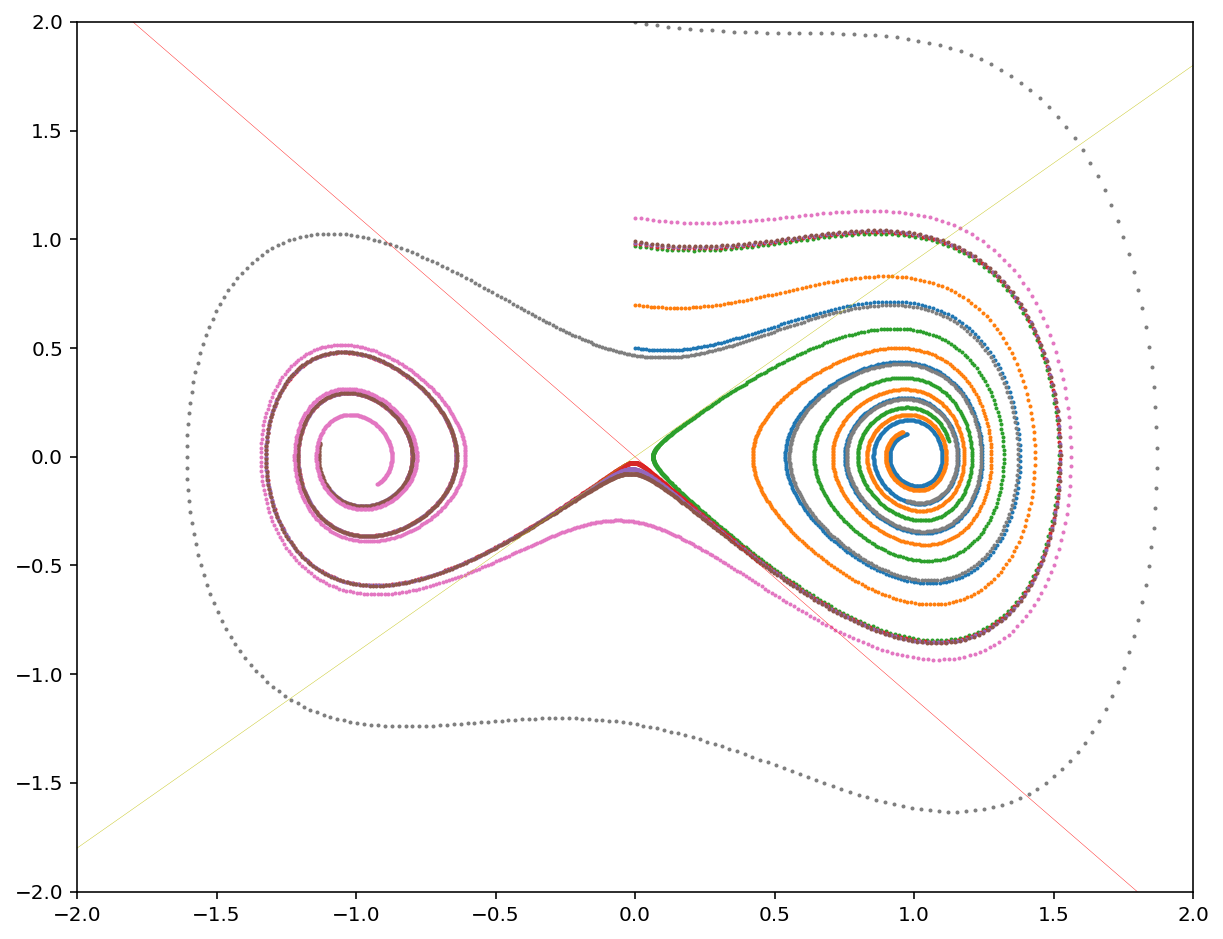

In [22]:
fig, ax = plt.subplots(figsize=(10,8))

for a in [.5, .7, .97, .98, .985, .99, 1.1,2]:
    flow = runge_kutta(f=lambda t,u: duffing(u, alpha=alpha_choice),
                       A = RK4A,
                       b = RK4b,
                       u_initial=np.array([.0, a]),
                       delta_t=delta_t)

    N = 20000
    firstN_values = list(itertools.islice(flow, 0, N, 20))
    x,y  = zip(*firstN_values)
    ax.scatter(x,y, s=1)

eigen_t = [-2, 2]

ax.plot(*zip(*[t*Jeigenvectors[0] for t in eigen_t]), 'r-', linewidth=.2, label="Eigenspace 1")
ax.plot(*zip(*[t*Jeigenvectors[1] for t in eigen_t]), 'y-', linewidth=.2, label="Eigenspace 2")


ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

We can use this plot to find a condition for convergence to (1,0). 

(_This is not a very solid proof_ 😢)

Suppose that $u$ is a solution to the initial value problem $u(0) = (0,a)$. 

Suppose that $u$ **crosses the line $(0,1] \times \{0\} \subseteq \mathbb{R}^2$**. In that case $u$ is _trapped_ between the top right yellow line and one of the paths we just computed. From the graph we can then deduce that $u$ **must converge to $(1,0)$**.

Because:
- Different paths cannot cross. (Otherwise they would be the same solution.)
- The top right yellow line **can only be crossed from left to right, since $\text{duff}(u)_0 > 0$ when $u_1 > 0$.**


Similarly, if $u$ **crosses the line $[-1,0) \times \{0\} \subseteq \mathbb{R}^2$ then $u$ must converge to $(-1,0)$**.

Let's use this observation to create a method that computes the point of convergence, given an initial value. We can simply keep iterating until the trajectory _crosses one of the two lines $(0,1] \times \{0\}$ or $[-1,0) \times \{0\}$_. In that case, we can safely conclude that the trajectory will converge to $(1,0)$ or $(-1,0)$, respectively.

In [130]:
def initial_value_converges_to(initial_value, delta_t=1e-3, max_iter = 20000):
    # If the initial value is already in a stationary point:
    if initial_value[1] == 0.0:
        if initial_value[0] == 0.0:
            return 0
        elif initial_value[0] == 1.0:
            return 1
        elif initial_value[0] == -1.0:
            return -1
    # Define the trajectory
    flow = runge_kutta(f=lambda t,u: duffing(u, alpha=alpha_choice),
                       A = RK4A,
                       b = RK4b,
                       u_initial=initial_value,
                       delta_t=delta_t)

    # Compute trajectory values:
    for i, (prev_point, next_point) in enumerate(successions(flow)):
        # We are looking for an iteration where the y-coordinate *changes sign* (goes from negative to positive, or vice versa)
        prev_sign = np.sign(prev_point[1])
        next_sign = np.sign(next_point[1])
        
        if prev_sign != next_sign:
            # Crossed the x-axis:
            if 0.0 < next_point[0] <= 1.1:
                return 1
            if -1.1 <= next_point[0] < 0.0:
                return -1
        
        # To avoid getting stuck:
        if i >= max_iter:
            print("Iteration limit exceeded", next_point)
            # If the final point is very very close to the origin, we could conclude that this trajectory converges to it.
            if np.abs(next_point).sum() < 1e-3:
                return 0
            # Otherwise, we are not sure
            return np.nan

In [31]:
for a in np.arange(.9, 1.0, .01):
    display(Markdown("(0.0, {0:0.2f}) converges to ({1}, 0)".format(a, initial_value_converges_to(np.array([0.0, a]), 1e-3))))

(0.0, 0.90) converges to (1, 0)

(0.0, 0.91) converges to (1, 0)

(0.0, 0.92) converges to (1, 0)

(0.0, 0.93) converges to (1, 0)

(0.0, 0.94) converges to (1, 0)

(0.0, 0.95) converges to (1, 0)

(0.0, 0.96) converges to (1, 0)

(0.0, 0.97) converges to (1, 0)

(0.0, 0.98) converges to (-1, 0)

(0.0, 0.99) converges to (-1, 0)

We are looking for a threshold value. We already know that this value lies in the interval $[0.9, 1.0]$. We can keep dividing this interval in two, and study the converging behaviour at the midpoint.

To get an accuracy of $0.001$, we simply keep dividing the interval until the interval has length $\leq0.001$.

In [164]:
def divide_and_compare(accuracy, bound_left, bound_right, value_right, return_bounds):
    while np.linalg.norm(bound_left - bound_right) > accuracy:
        midpoint = (bound_left + bound_right)/2
        if initial_value_converges_to(midpoint, delta_t=2e-3, max_iter=50000) == value_right:
            bound_right = midpoint
        else:
            bound_left = midpoint
    if return_bounds:
        return bound_left, bound_right
    return (bound_left + bound_right) / 2

In [165]:
a1_bound_left, a1_bound_right = divide_and_compare(.001, np.array([0, .9]), np.array([0, 1]), -1, True)

a1 = ((a1_bound_right + a1_bound_left)/2)[1]
display(Markdown("$a_1 \cong {:.3f}$".format(a1)))

$a_1 \cong 0.979$

--------
**d), f)** and **h)** are combined into one figure, which we will come back to later.

------
**e):**
We can use the same method as before. Using trial and error, we find that $a_2$ must lie somewhere between $a_1$ and $2.0$.

In [157]:
a2_bound_left, a2_bound_right = divide_and_compare(0.001, a1_bound_right, np.array([0.0,2.0]), 1, True)

a2 = ((a2_bound_right + a2_bound_left)/2)[1]
display(Markdown("$a_2 \cong {:.3f}$".format(a2)))

$a_2 \cong 1.731$

------
**g):**
We can use the same method as before. Let's try some values to find lower and upper bounds for $a_3$.

In [152]:
for a in [a1_bound_left[1],a1_bound_right[1], a2_bound_left[1], a2_bound_right[1], 2.0, 2.5, 3.0, 3.5]:
    print("(0,{0}) converges to ({1},0)".format(a,initial_value_converges_to(np.array([0.0, a]))))

(0,0.9781249999999999) converges to (1,0)
(0,0.9789062499999999) converges to (-1,0)
(0,1.7307662963867185) converges to (-1,0)
(0,1.7317634582519528) converges to (1,0)
(0,2.0) converges to (1,0)
(0,2.5) converges to (1,0)
(0,3.0) converges to (-1,0)
(0,3.5) converges to (1,0)


So let's look for a threshold **between 2.5 and 3.0**. (Maybe it's $e=2.71...$ 😲)

In [199]:
a3_bound_left, a3_bound_right = divide_and_compare(0.001, np.array([0.0,2.5]), np.array([0.0,3.0]), -1, True)

a3 = ((a3_bound_right + a3_bound_left)/2)[1]
display(Markdown("$a_3 \cong {0:.3f}$".format(a3)))

$a_3 \cong 2.547$

Which is **1 US inch converted to centimeters**, of course! 📏

-----
**d), f)** and **h):**

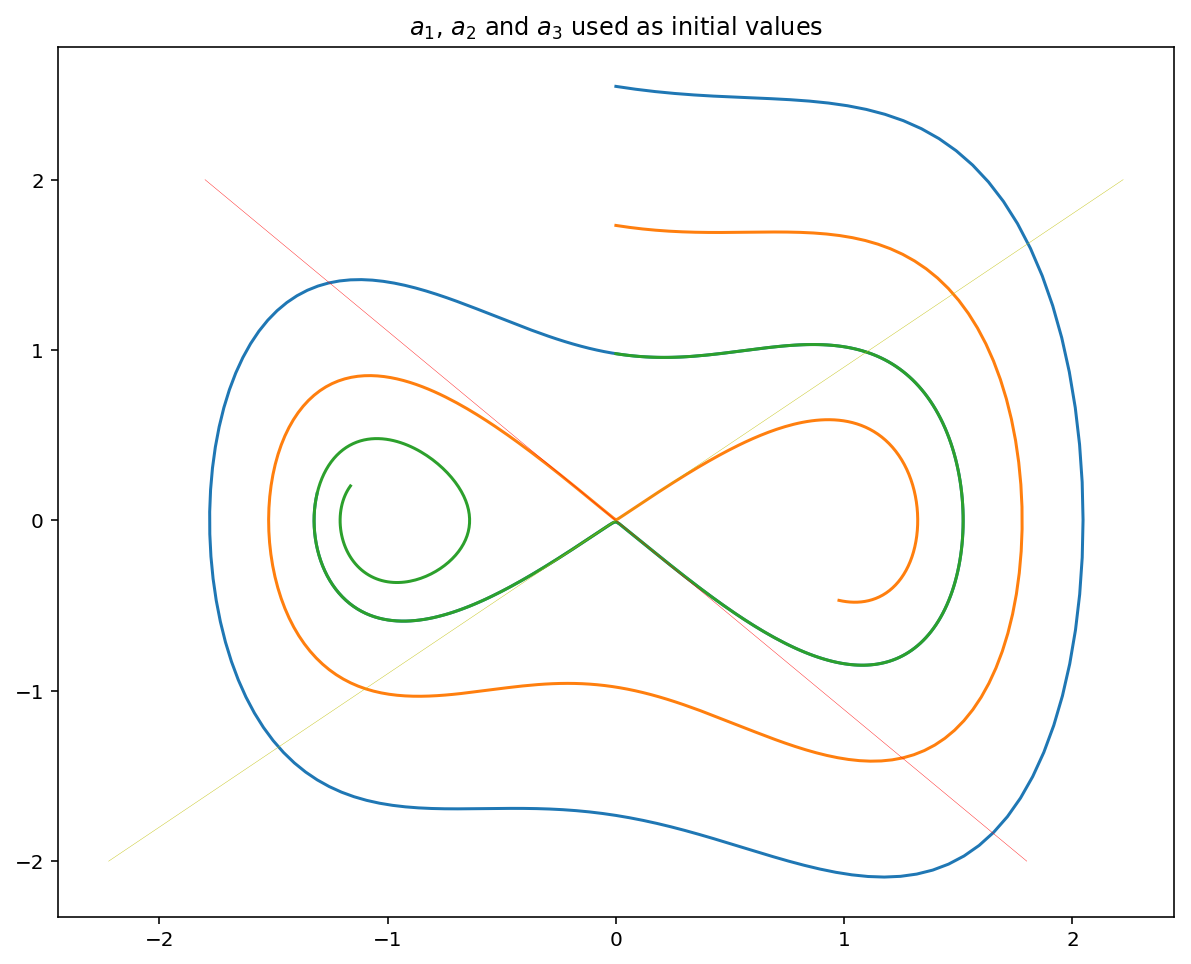

In [203]:
fig, ax = plt.subplots(figsize=(10,8))

for a in [a3, a2, a1]:
    flow = runge_kutta(f=lambda t,u: duffing(u, alpha=alpha_choice),
                       A = RK4A,
                       b = RK4b,
                       u_initial=np.array([0.0,a]),
                       delta_t=delta_t)

    N = 20000
    firstN_values = list(itertools.islice(flow, 0, N, 34))
    x,y  = zip(*firstN_values)
    ax.plot(x,y)#, s=1)

eigen_t = [-2, 2]

ax.plot(*zip(*[t*Jeigenvectors[0] for t in eigen_t]), 'r-', linewidth=.2, label="Eigenspace 1")
ax.plot(*zip(*[t*Jeigenvectors[1] for t in eigen_t]), 'y-', linewidth=.2, label="Eigenspace 2")

ax.set_title("$a_1$, $a_2$ and $a_3$ used as initial values")
plt.show()

We see that the trajectories are very close to the those that we got when using the eigenvalues as initial values. However, since the origin is not a stable equilibrium, the trajectories don't converge at the origin.

Note that the trajectory resulting from the initial value $a_3$ passes through $a_1$: they are the same trajectory.

--------
**i):**

It seems like the trajectories that we just found are the border between the two areas $\mathcal{D}_+$ and $\mathcal{D}_-$.

Let's dicretise the $[-2, 2] \times [-2, 2]$ rectangle, and compute the convergence of those points. We can then draw a contour plot, to visualise the convergence basins.

In [178]:
resolution = 20

# Since the differential equation is odd (i.e. duff(-u) = -duff(u)), we only need to compute the top half:
x_vals = np.linspace(-2.0,2.0, num=resolution*2)
y_vals = np.linspace(0.0,2.0, num=resolution)

grid_points = np.array([[x,y] for x in x_vals for y in y_vals])

convergence_map = np.apply_along_axis(lambda u: initial_value_converges_to(u, 5e-2, max_iter=5000), 1, grid_points)
convergence_map = convergence_map.reshape((resolution*2, resolution)).T

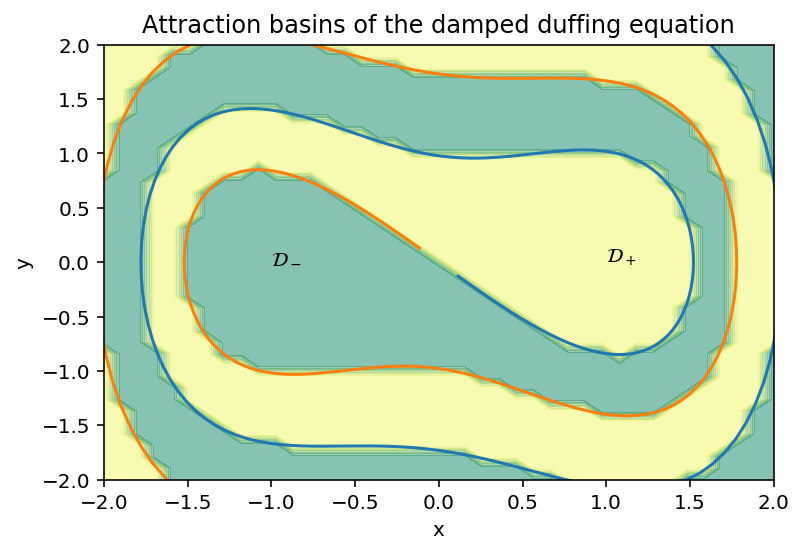

In [214]:
bottom_map = -convergence_map[::-1,::-1]
total_map = np.append(bottom_map, convergence_map, axis=0)


fig, ax = plt.subplots(figsize=(6,4))

ax.contourf(x_vals, np.append(-2.0+y_vals, y_vals), total_map, alpha=.5, cmap=plt.get_cmap('summer'))

flow = runge_kutta(f=lambda t,u: duffing(u, alpha=alpha_choice),
                   A = RK4A,
                   b = RK4b,
                   u_initial=np.array([0.0, a3]),
                   delta_t=delta_t_crude)

N = 5000
firstN_values = list(itertools.islice(flow, 0, N, 20))
x,y  = zip(*firstN_values)
ax.plot(x,y)#, s=4, c='#808000')
ax.plot(-np.array(x),-np.array(y))#, s=4, c='#000080')

plt.annotate("$\mathcal{D}_+$", [1,0])
plt.annotate("$\mathcal{D}_-$", [-1,0])

ax.set_title("Attraction basins of the damped duffing equation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.show()

In [ ]:
from functools import reduce

key = "🐋🐑🐠🐸🦝🐨"

str_to_int = ord
encode = lambda i: encode(i//6)+key[i%6] if i else ""
decode = lambda e: reduce(lambda a,b: 6*a + b, map(key.index, e))
int_to_str = chr

#geheim = [encode(str_to_int(s)) for s in "???"]
geheim = ['🐠🐋🐋', '🐸🐋🐸', '🐠🐨🐸', '🐨🐠', '🐠🐠🐋', '🐠🦝🐨', '🐸🐠🐑', '🐨🐸', '🐨🐠', '🐠🦝🐠🦝🐨🐋🐠']

print("".join(int_to_str(decode(e)) for e in geheim))